In [1]:
%pip install keras
%pip install tensorflow
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

In [3]:
data = pd.read_csv("VNM.csv", parse_dates=['Date'], dayfirst=False, thousands=',', decimal='.')
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-31,63400.0,63400.0,63800.0,63300.0,1.64M,0.16%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1.49M,-0.78%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2.44M,0.00%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1.71M,-0.16%
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1.30M,0.16%
...,...,...,...,...,...,...,...
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729.69K,1.46%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176.98K,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220.82K,0.74%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161.84K,0.00%


In [4]:
# Đổi tên các cột thành tiếng Anh cho dễ làm việc
data.rename(columns={
    "Price": "Close",
    "Vol.": "Volume",
}, inplace = True)
data

,Date,Close,Open,High,Low,Volume,Change %
0,2024-12-31,63400.0,63400.0,63800.0,63300.0,1.64M,0.16%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1.49M,-0.78%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2.44M,0.00%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1.71M,-0.16%
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1.30M,0.16%
...,...,...,...,...,...,...,...
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729.69K,1.46%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176.98K,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220.82K,0.74%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161.84K,0.00%


<Axes: >

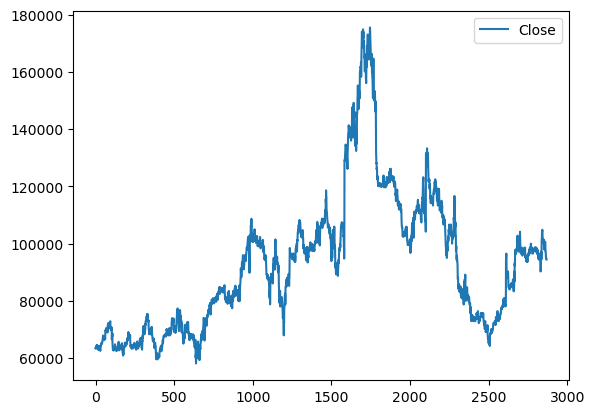

In [5]:
data.plot.line(y="Close", use_index = True)

In [6]:
#convert M L K trong cột KL thành số thực
def convert_volume(vol_str):
    if isinstance(vol_str, str):
        if vol_str[-1] == 'M':
            return float(vol_str[:-1]) * 1_000_000
        elif vol_str[-1] == 'K':
            return float(vol_str[:-1]) * 1_000
    return float(vol_str)

data['Volume'] = data['Volume'].apply(convert_volume)
data = data.sort_values('Date')
data = data.ffill()
data

,Date,Close,Open,High,Low,Volume,Change %
2867,2013-07-10,94444.0,95139.0,95833.0,94444.0,232110.0,0.00%
2866,2013-07-11,94444.0,94444.0,95139.0,93750.0,161840.0,0.00%
2865,2013-07-12,95139.0,94444.0,95139.0,93750.0,220820.0,0.74%
2864,2013-07-15,95139.0,95139.0,95833.0,94444.0,176980.0,0.00%
2863,2013-07-16,96528.0,95139.0,97222.0,95139.0,729690.0,1.46%
...,...,...,...,...,...,...,...
4,2024-12-25,63900.0,63900.0,64396.1,63900.0,1300000.0,0.16%
3,2024-12-26,63800.0,64200.0,64200.0,63800.0,1710000.0,-0.16%
2,2024-12-27,63800.0,63900.0,64100.0,63700.0,2440000.0,0.00%
1,2024-12-30,63300.0,63600.0,63700.0,63300.0,1490000.0,-0.78%


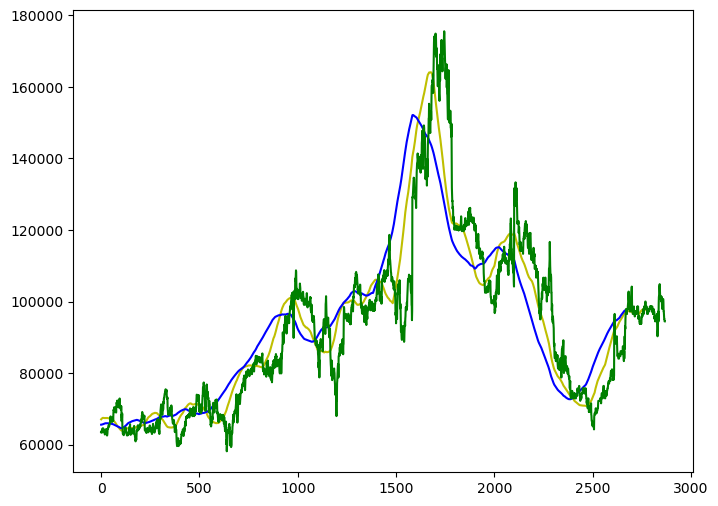

In [7]:
# Them chi bao MA100, MA200

ma_100 = data.Close.rolling(100).mean()
ma_200 = data.Close.rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100, 'y')
plt.plot(ma_200, 'b')
plt.plot(data.Close, 'g')
plt.show()

In [8]:
# Xu ly du lieu loi

data.dropna(inplace=True)

In [9]:
# Chia tap train tap test

data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [10]:
data_train.shape[0]

2294

In [11]:
data_test.shape[0]

574

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))

In [13]:
data_train_scale = scaler.fit_transform(data_train)

In [14]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [15]:
x, y = np.array(x), np.array(y)

In [16]:
# Build model LSTM

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

In [17]:
# Toi uu bang adam, error tinh bang MSE

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [18]:
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
69/69 [==============================] - 16s 183ms/step - loss: 0.0248
Epoch 2/50
69/69 [==============================] - 13s 184ms/step - loss: 0.0066
Epoch 3/50
69/69 [==============================] - 13s 185ms/step - loss: 0.0064
Epoch 4/50
69/69 [==============================] - 13s 188ms/step - loss: 0.0052
Epoch 5/50
69/69 [==============================] - 13s 188ms/step - loss: 0.0048
Epoch 6/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0052
Epoch 7/50
69/69 [==============================] - 13s 187ms/step - loss: 0.0048
Epoch 8/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0042
Epoch 9/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0040
Epoch 10/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0038
Epoch 11/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0038
Epoch 12/50
69/69 [==============================] - 13s 189ms/step - loss: 0.0039
Epoch 13/50
6

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [20]:
pas_100_days = data_train.tail(100)

In [21]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [22]:
data_test_scale  =  scaler.fit_transform(data_test)

In [23]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

In [24]:
y_predict = model.predict(x)

18/18 [==============================] - 2s 56ms/step


In [25]:
scale = 1/scaler.scale_

In [26]:
y_predict = y_predict*scale

In [27]:
y = y*scale

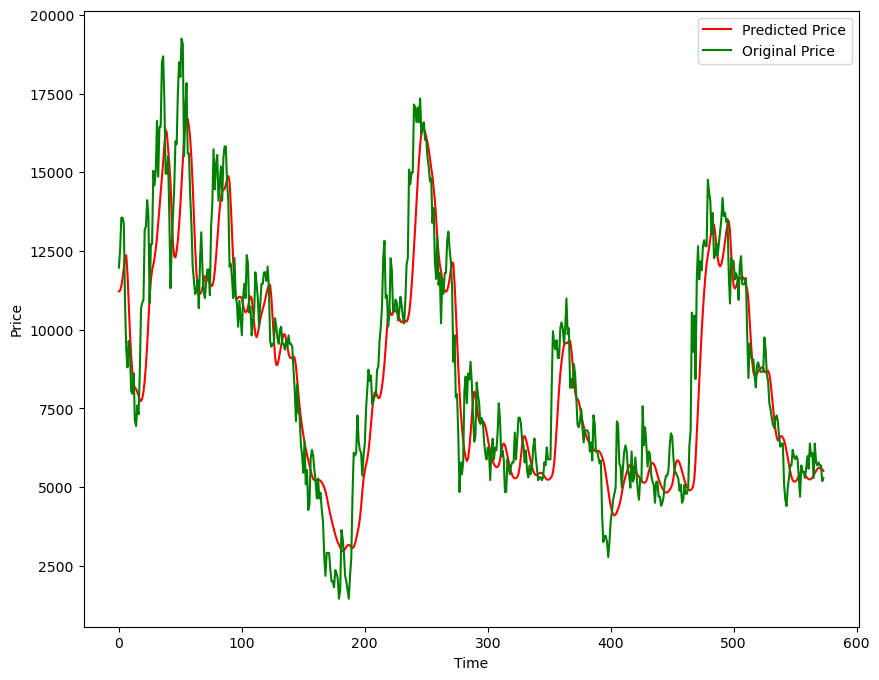

In [28]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
def add_target_columns(data):
    data['Target_5'] = data['Close'].shift(-5)
    data['Target_10'] = data['Close'].shift(-10)
    data['Target_20'] = data['Close'].shift(-20)

In [30]:
def add_features(data):
    #%chênh giá mở và đóng, chênh giá đỉnh và sàn
    data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']
    data['High_Low_Spread'] = (data['High'] - data['Low']) / data['Open']

    #xem xu hướng của giá cổ phiếu dựa trên trung bình 15, 10 và 20 ngày gần nhất
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA20'] = data['Close'].rolling(window=20).mean()

    #xem độ biến động thông qua độ lệch chuẩn của giá 5 ngày
    data['Volatility_5'] = data['Close'].rolling(window=5).std()
    data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
    data['Volume_Spike'] = (data['Volume'] > 1.5 * data['Volume'].rolling(window=20).mean()).astype(int)

In [31]:
add_features(data)
add_target_columns(data)
print(data.columns)

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change %',
       'Daily_Return', 'High_Low_Spread', 'MA5', 'MA10', 'MA20',
       'Volatility_5', 'Volume_MA5', 'Volume_Spike', 'Target_5', 'Target_10',
       'Target_20'],
      dtype='object')


In [32]:
data['DayOfWeek'] = data['Date'].dt.dayofweek

In [33]:
def prepare_data_for_predicting_n_days_ahead(tbl, n: str):
    if (n != '5' and n != '10' and  n != '20'):
        return 0
        
    X_cols = ['Daily_Return', 'High_Low_Spread', 'MA5', 'MA10', 
        'MA20', 'Volatility_5', 'Volume_MA5', 'Volume_Spike', 'DayOfWeek']
    y_col = ['Target_' + n]
    needed_cols = X_cols + y_col

    temp1 = tbl[needed_cols].ffill().bfill()
    X = temp1[X_cols]
    y = temp1[y_col]

    split_point = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:] 
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
#sua tam de chay cho nhanh
model_rfr = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error', n_iter=10)
model_rfr_raw = RandomForestRegressor(n_estimators=100, random_state=42)

In [35]:
def train(X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train, y_train.values.ravel())
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    return y_pred

In [36]:
def plot_the_diff(y_test, y_pred, n: str, name: str):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Price', color='blue')
    plt.plot(y_pred, label='Predicted Price', color='red')
    plt.legend()
    plt.title(f'{name}: Actual vs Predicted Prices ({n} days)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

In [37]:
def temp2(df: pd.DataFrame, name: str, model):
    for n in ['5', '10', '20']:
        X_train, X_test, y_train, y_test = prepare_data_for_predicting_n_days_ahead(df, n)
        y_pred = train(X_train, X_test, y_train, y_test, model)
        plot_the_diff(y_test, y_pred, n, name)

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 7249444.49
R^2 Score: 0.49


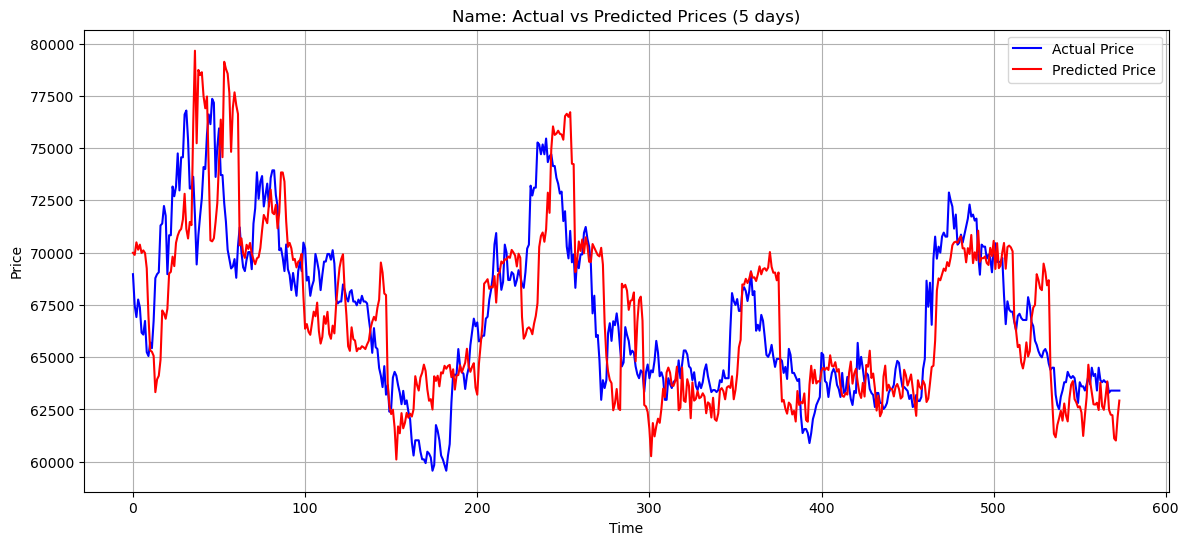

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 11349202.20
R^2 Score: 0.20


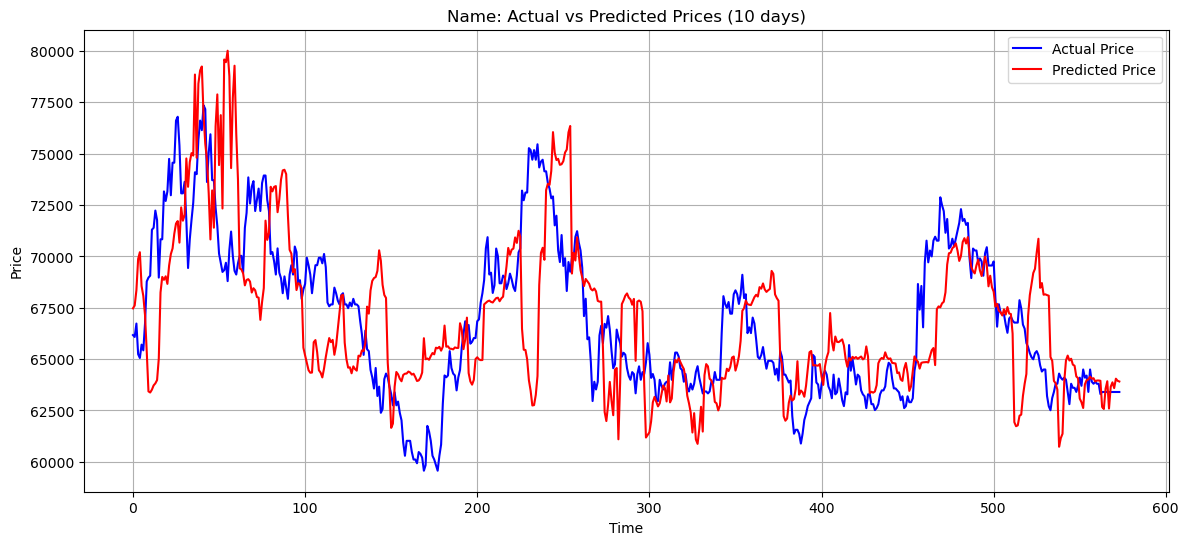

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 20055422.43
R^2 Score: -0.39


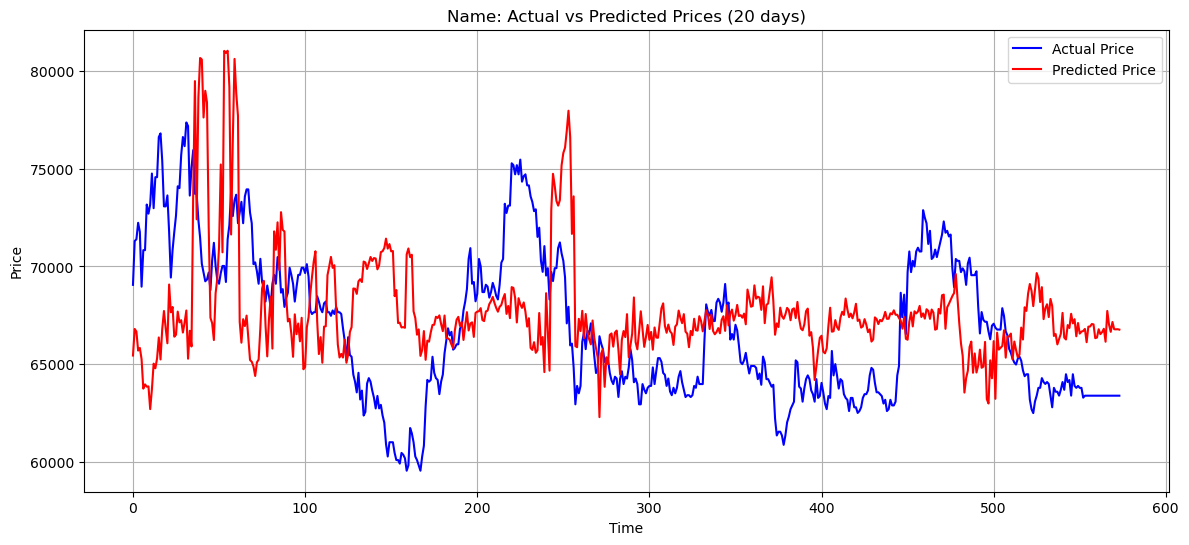

In [38]:
temp2(data, 'Name', model_rfr_raw)

In [39]:
param_grid_x = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
#sua tam de chay cho nhanh dung xoa
model_xgbr = RandomizedSearchCV(XGBRegressor(), param_grid_x, cv=3, scoring='neg_mean_squared_error', n_iter=10)
model_xgbr_raw = RandomForestRegressor(n_estimators=100, random_state=42)

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 7249444.49
R^2 Score: 0.49


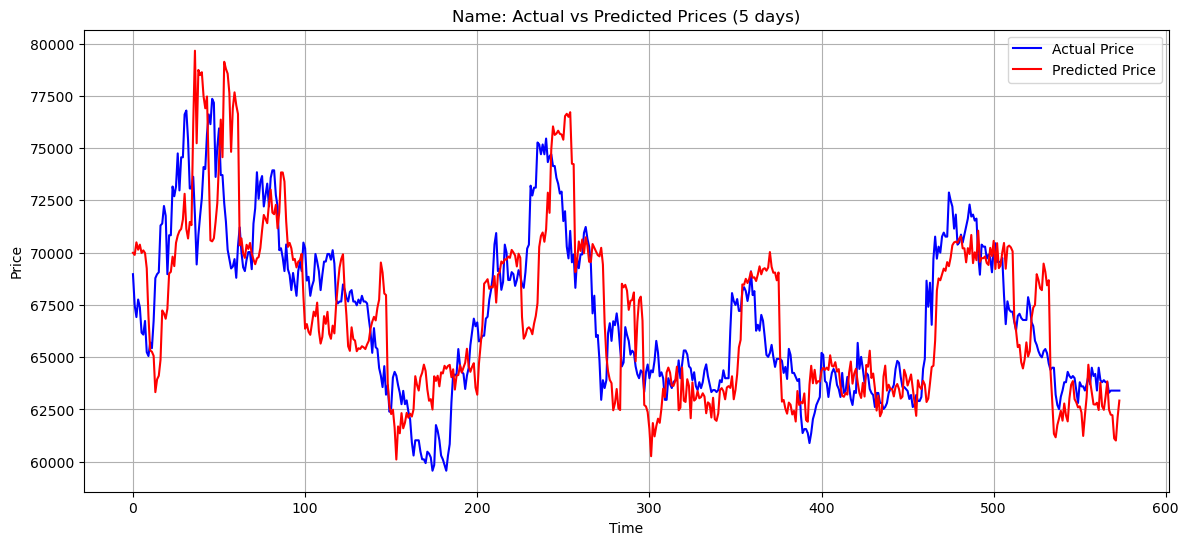

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 11349202.20
R^2 Score: 0.20


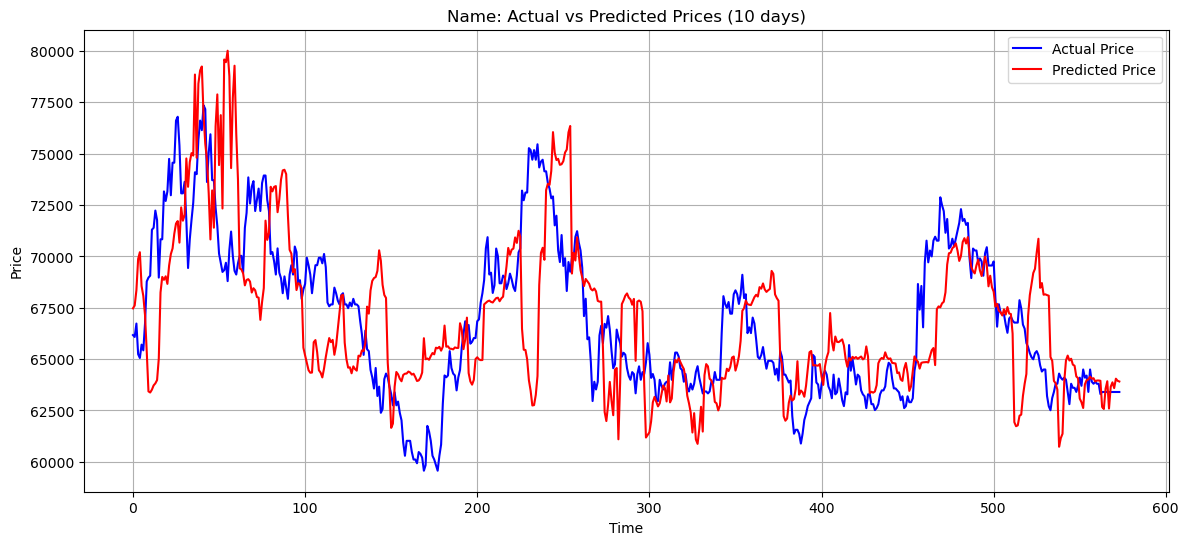

(2294, 9) (574, 9) (2294, 1) (574, 1)
Mean Squared Error (MSE): 20055422.43
R^2 Score: -0.39


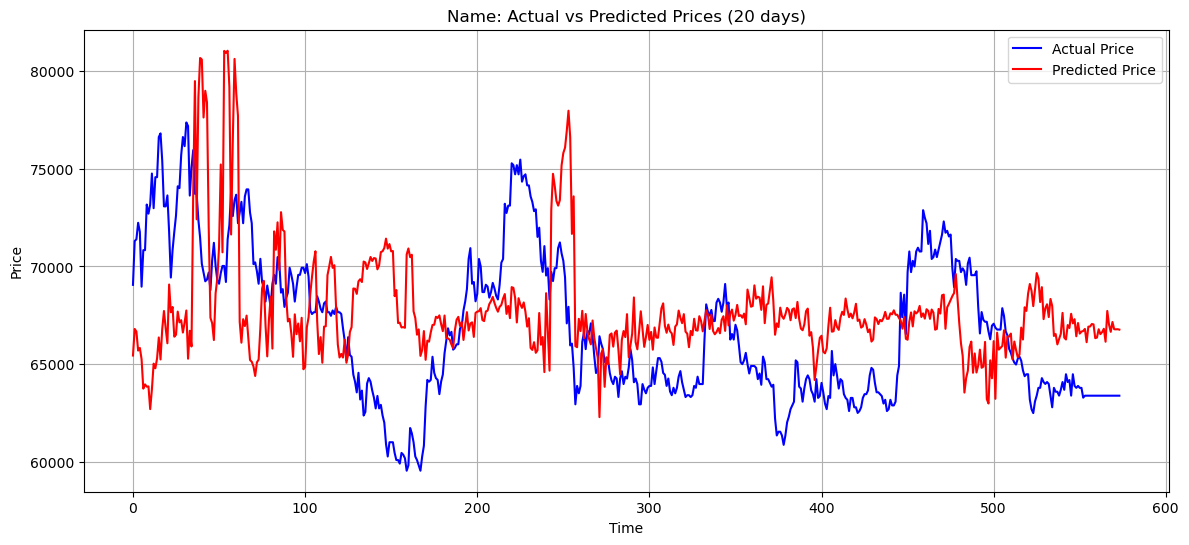

In [40]:
temp2(data, 'Name', model_xgbr_raw)

In [41]:
model.save('Predictors.keras')